In [1]:
%load_ext autoreload
%autoreload 2


%pylab inline

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

import numpy as np
import tqdm
import torch

from models import ResNet, weights_init
from utils import get_dataloader

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


root = './afhq/train/'
LABELS = {}
for idx, n_cat in enumerate(sorted(os.listdir(root))):
    LABELS[idx] = n_cat
LABELS


def listdir(dname):
    fnames = list(chain(*[list(Path(dname).rglob('*.' + ext)) for ext in ['png','jpg','jpeg','JPG']]))
    return fnames

# Not necessary since ImageFolder from torchvision already implemented
class AnimalDataset(Dataset):
    def __init__(self, root, transform = None):
        self.samples, self.targets = self._make_dataset(root)
        self.transform = transform

    def _make_dataset(self,root):
        classes = os.listdir(root)
        fnames, labels = [],[]
        for idx, domain in enumerate(sorted(classes)):
            class_fnames = listdir(os.path.join(root, domain))
            fnames += class_fnames
            labels += [idx] * len(class_fnames)

        return fnames, labels

    def __getitem__(self,idx):
        fname, label = self.samples[idx], self.targets[idx]
        img = Image.open(fname).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, label
    def __len__(self):
        return len(self.targets)
    
            

In [2]:
dataloader = get_dataloader(batch_size = 8, split = 'train')

In [3]:
train_dat, train_labels = next(iter(dataloader))


In [4]:
grid = torchvision.utils.make_grid(train_dat, nrow = 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


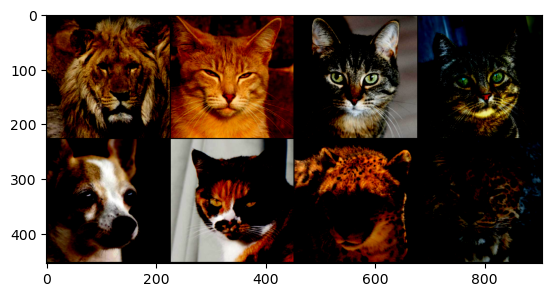

In [5]:
imshow(grid.permute(1,2,0))

In [6]:
device = torch.device('cuda')

In [7]:
model = ResNet(3)
model.apply(weights_init)
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 30, verbose = True)

In [8]:
epochs = 3
BS = 256
losses = []

loader = get_dataloader(batch_size = BS)

In [8]:
for _ in range(epochs):
    pbar = tqdm.tqdm(loader)
    for i, dat in enumerate(pbar):
        X = dat[0].to(device)
        y = dat[1].to(device)
        out = model(X)
        loss = loss_fn(out,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step(loss)
        
        pbar.set_description(f'Loss: %.3f' % loss.item())
        losses.append(loss.item())
    

Loss: 0.127:  22%|██▏       | 50/229 [00:49<02:56,  1.01it/s]


KeyboardInterrupt: 

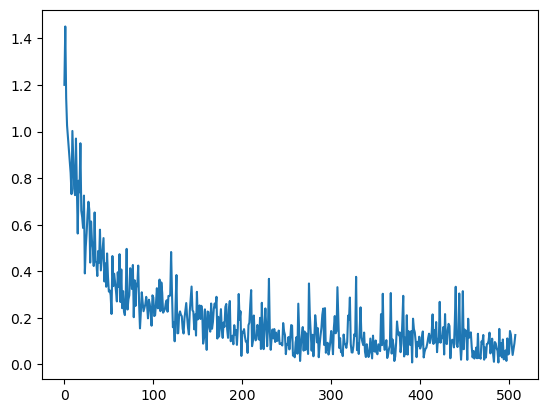

In [9]:
plot(losses)

In [9]:
'''transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
data_val = torchvision.datasets.ImageFolder(root_val, transform)'''
#loader_val = DataLoader(data_val, batch_size = 256, shuffle = True)
loader_val = get_dataloader(split = 'val',batch_size = 32)

In [10]:
iter_data = iter(loader_val)
X,y = next(iter_data)

In [11]:
X, y = X.to(device), y.to(device)
out = model(X)
loss = loss_fn(out,y)
loss.item()

0.04501841589808464

In [8]:
#model.load_state_dict(torch.load('./model_weight_better.pth'))

<All keys matched successfully>

In [17]:
#torch.save(model.state_dict(), './model_weight_better.pth')

In [12]:
torch.sum(torch.argmax(out, dim = -1)==y)

tensor(32, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


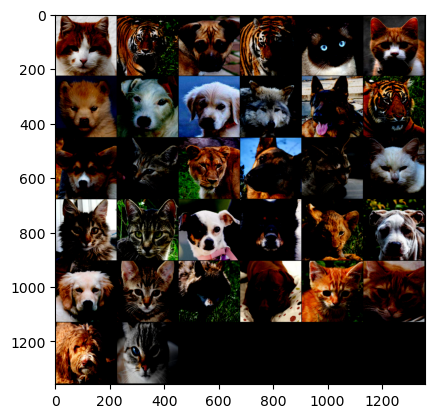

In [13]:
grid_val = torchvision.utils.make_grid(X[:36].detach().cpu(), nrow = 6)
imshow(grid_val.permute(1,2,0))

In [9]:
from models import Discriminator, Generator
disc = Discriminator(img_channel = 3)
disc = disc.to(device)

latent_dim = 100

gen = Generator(latent_dim)
gen = gen.to(device)


In [10]:
def create_fake_samples(batch_size, latent_dim, generator):
    dev = generator.ln.weight.device
    noise = torch.randn((batch_size,latent_dim)).to(dev)
    fake = generator(noise)
    fake_target = torch.zeros(batch_size,1).to(dev)
    return fake, fake_target

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [11]:
disc.apply(weights_init)
gen.apply(weights_init)

Generator(
  (ln): Linear(in_features=100, out_features=25088, bias=True)
  (conv1T): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2T): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3T): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4T): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5T): ConvTranspose2d(64, 3, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
)

In [12]:
loss_fn = nn.BCELoss()
lr = 0.002
optimizer_discr = torch.optim.AdamW(disc.parameters(), lr = lr)
optimizer_gen = torch.optim.AdamW(gen.parameters(), lr = lr)
losses_discr = []
losses_gen = []

pbar = tqdm.tqdm(loader)
for dat in pbar:
    X_real = dat[0].to(device)
    y_real = torch.ones(X_real.shape[0],1).to(device)
    X_fake, y_fake = create_fake_samples(BS, latent_dim, gen)

    disc.zero_grad()

    out_real = disc(X_real)

    loss_discr = loss_fn(out_real,y_real)
    
    out_fake = disc(X_fake.detach())
    loss_discr += loss_fn(out_fake, y_fake)
    

    loss_discr.backward()
    optimizer_discr.step()
    
    
    losses_discr.append(loss_discr.item())
    gen.zero_grad()
    y_gen = torch.ones(BS,1).to(device)
    out = disc(X_fake)
    loss_gen = loss_fn(out, y_gen)
    losses_gen.append(loss_gen.item())

    loss_gen.backward()
    optimizer_gen.step()

    pbar.set_description(f'Loss D: %.3f, loss G: %.3f' % (loss_discr.item(), loss_gen.item()))


    

Loss D: 100.000, loss G: 0.000:  24%|██▍       | 14/58 [14:13<44:43, 60.99s/it]


KeyboardInterrupt: 

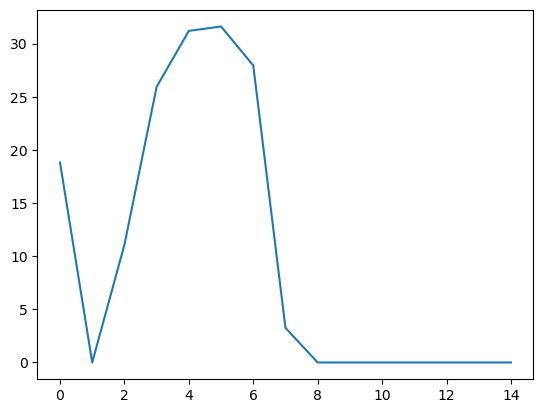

In [13]:
plot(losses_gen)

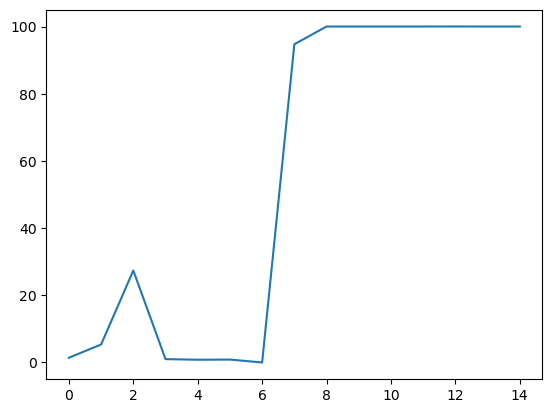

In [14]:
plot(losses_discr)

In [15]:
X_fake

tensor([[[[-5.3079e-02, -8.7473e-01, -2.3809e-02,  ...,  6.0513e-02,
           -1.3338e-02,  1.4756e-01],
          [-6.0748e-01, -9.9742e-01, -5.4728e-01,  ...,  4.8879e-02,
            4.1963e-01,  1.9074e-01],
          [ 6.1764e-01, -9.5784e-01, -6.2682e-01,  ..., -1.8214e-01,
            6.1596e-02, -1.6131e-01],
          ...,
          [ 3.1303e-01,  1.1186e-01,  5.1941e-01,  ...,  2.0734e-01,
            4.7620e-01,  1.9025e-01],
          [ 1.1147e-01,  2.1234e-02,  1.4311e-01,  ..., -1.6598e-03,
            1.0564e-01,  5.0644e-03],
          [ 2.6233e-01,  1.0736e-01,  3.9859e-01,  ...,  6.0710e-02,
            3.6157e-01,  9.8762e-02]],

         [[-5.6359e-01, -8.0453e-01, -3.2572e-01,  ...,  5.1162e-02,
           -1.2209e-01, -1.5159e-02],
          [ 8.7909e-01, -7.1623e-01,  8.5376e-01,  ..., -3.7598e-01,
           -1.0113e-01, -1.0337e-01],
          [ 3.3471e-01, -8.4715e-02,  7.0196e-01,  ..., -2.8593e-02,
           -2.8265e-01, -1.0813e-01],
          ...,
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


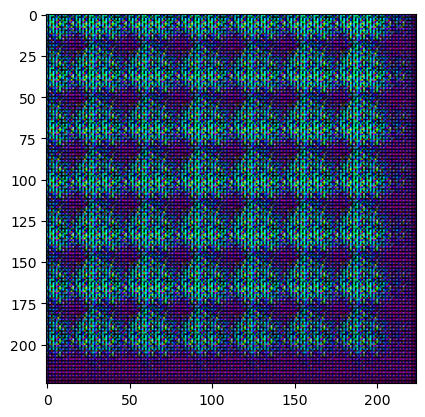

In [16]:
imshow(X_fake[0].detach().cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


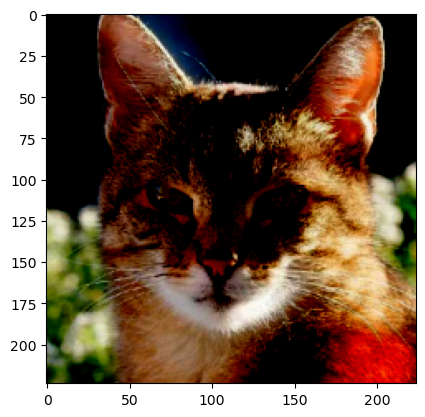

In [17]:
imshow(X_real[0].detach().cpu().permute(1,2,0))